# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scipy as sp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [8]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [9]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [10]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [11]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [12]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [14]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


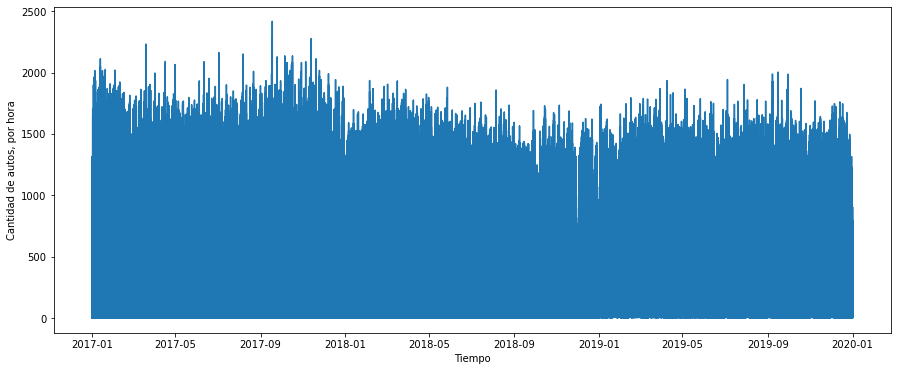

In [15]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [16]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


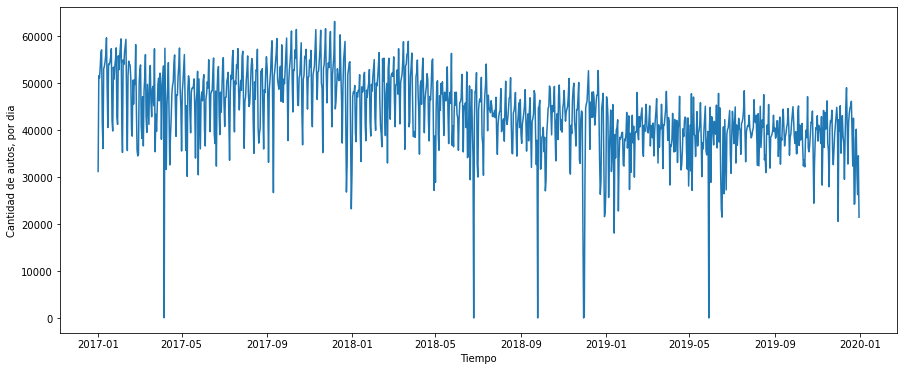

In [17]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

### Exploración de datos

#### Outliers

El gráfico anterior evidencia la existencia de outliers, por lo cual se procede a removerlos.

In [18]:
#Detección y reemplazo de valores atípicos
diario.cantidad_pasos[diario.cantidad_pasos < 10000] = np.nan

diario['cantidad_pasos']=diario.cantidad_pasos.fillna(diario.cantidad_pasos.rolling(4, min_periods=1).mean())

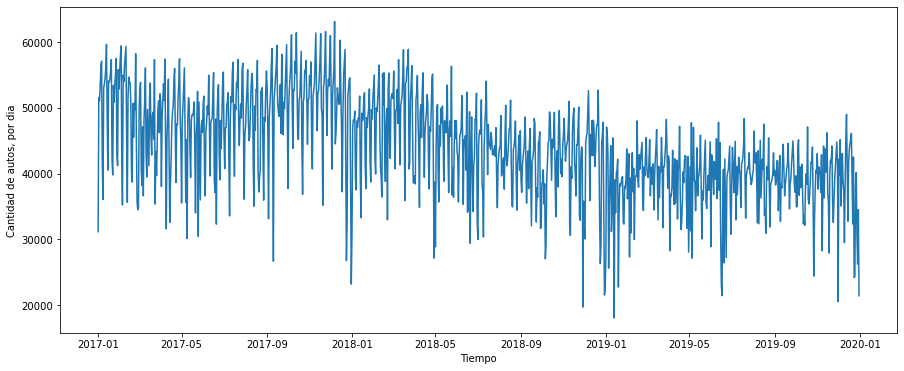

In [19]:
#Gráfico de cantidad de autos por día 
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

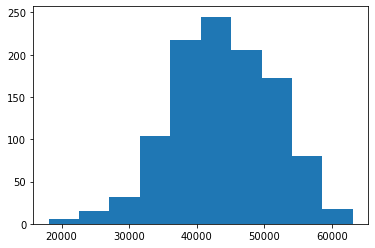

In [20]:
#Histograma para analizar la distribución de la cantidad de pasos por día
plt.hist(diario.cantidad_pasos)
plt.show()

**Analisis**: puede apreciarse una distribución normal de la cantidad de pasos por día, con una media aproximada de 40.000 pasos diarios.

In [21]:
#Copia del dataset original
dt_original = diario.copy()
dt_original.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


<AxesSubplot:xlabel='fecha'>

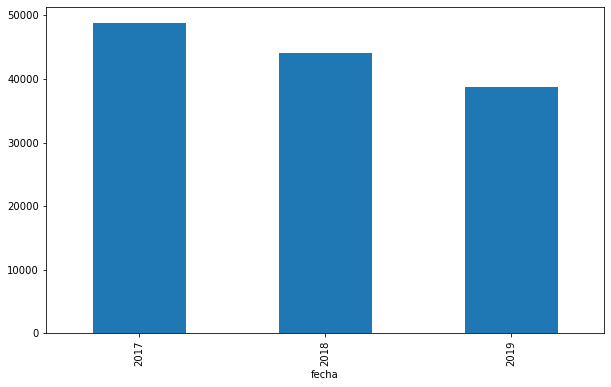

In [22]:
#Promedio de pasos diarios por año
dt_original.reset_index(inplace=True)
plt.figure(figsize = (10,6))
dt_original.groupby(dt_original.fecha.dt.year)['cantidad_pasos'].mean().plot.bar()

**Analisis**: puede apreciarse que la media de pasos diarios fue disminuyendo año a año.

<AxesSubplot:xlabel='fecha'>

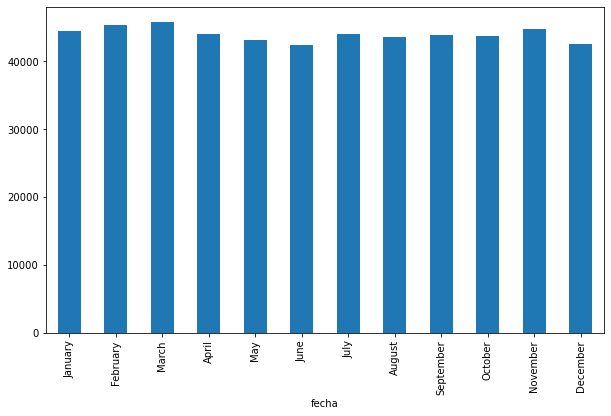

In [23]:
#Promedio de pasos diarios por mes
dt_original.reset_index(inplace=True)
plt.figure(figsize = (10,6))
dt_original.groupby(dt_original.fecha.dt.month_name(), sort=False)['cantidad_pasos'].mean().plot.bar()

**Analisis**: al estudiar los promedios diarios por mes, no pareciera haber grandes variaciones entre los distintos meses del año.

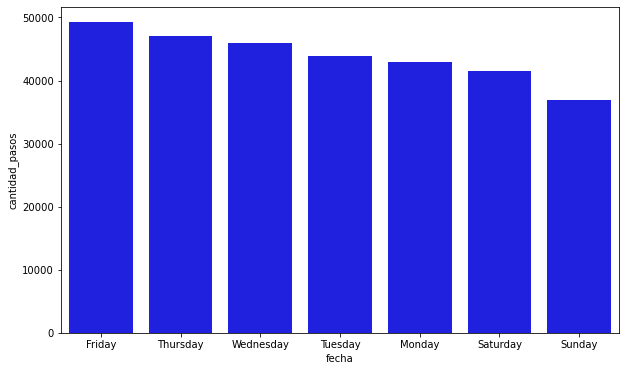

In [24]:
#Promedio de pasos diarios por día de la semana
dias= dt_original.groupby(dt_original.fecha.dt.day_name()).mean().sort_values('cantidad_pasos', ascending=False)
dias.reset_index(inplace=True)
plt.figure(figsize = (10,6))
columns = dias.cantidad_pasos
sns.barplot(x=dias.fecha, y = columns,color='blue')
plt.show()

**Analisis**: en primer lugar, puede observarse que los días de la semana con menor promedio de pasos diarios son aquellos correspondientes al fin de semana (sábado y domingo). Luego, puede apreciarse que a medida que avanza la semana a partir del lunes, el promedio va en aumento, siendo el día viernes aquel con promedio más alto. Una posible explicación para esto puede ser la afluencia de tránsito con dirección a la Provincia de Buenos Aires por el fin de semana.

In [25]:
#Variable de fin de semana
dt_original['day of week']=dt_original['fecha'].dt.dayofweek
temp=dt_original['fecha']

In [26]:
#Definición de la función "fin de semana"
def applyer(row):
    if row.dayofweek== 5 or row.dayofweek==6:
        return 1
    else:
        return 0
    
temp2=dt_original['fecha'].apply(applyer)
dt_original['weekend']=temp2

<AxesSubplot:xlabel='weekend'>

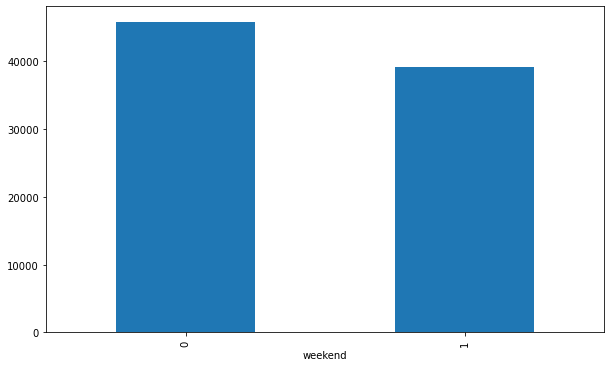

In [27]:
#Conteo por variable fin de semana
plt.figure(figsize = (10,6))
dt_original.groupby('weekend')['cantidad_pasos'].mean().plot.bar()

**Analisis**: como era de esperar en base al gráfico anterior, los días correspondientes al fin de semana tienen un promedio de pasos diarios menor al promedio de lunes a viernes.

#### Resampleos

In [28]:
#Resampleo semanal
semanal = dataset.resample('W', on = 'fecha').mean().reset_index()
semanal.head()

,fecha,cantidad_pasos
0,2017-01-01,134.991342
1,2017-01-08,159.344654
2,2017-01-15,168.002293
3,2017-01-22,162.963047
4,2017-01-29,161.540319


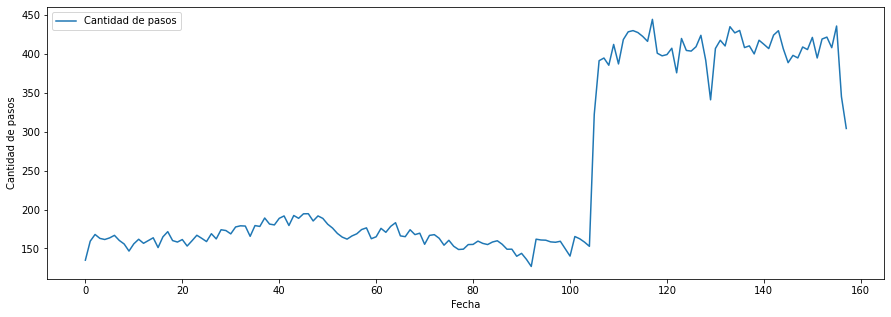

In [29]:
#Gráfico del resampleo semanal
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Cantidad de pasos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

In [30]:
#Resampleo mensual
mensual = dataset.resample('M', on = 'fecha').mean().reset_index()
mensual.head()

,fecha,cantidad_pasos
0,2017-01-31,162.590631
1,2017-02-28,158.464659
2,2017-03-31,158.481380
3,2017-04-30,162.467187
4,2017-05-31,158.675688


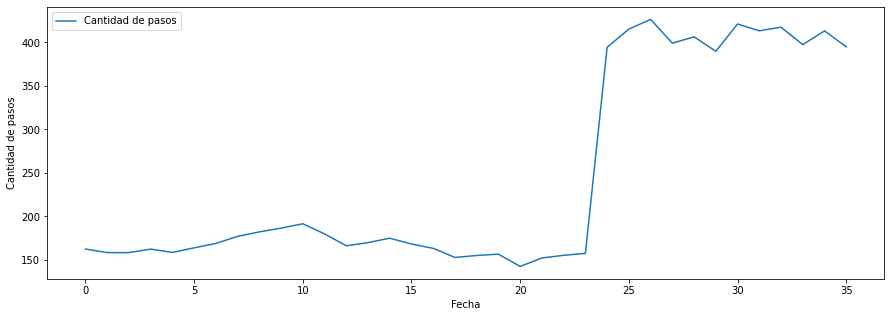

In [31]:
#Gráfico del resampleo mensual
plt.figure(figsize = (15,5))
plt.plot(mensual.index, mensual.cantidad_pasos, label = 'Cantidad de pasos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

#### Autocorrelaciones

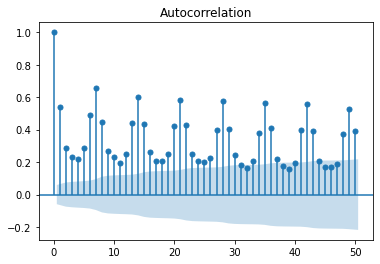

In [32]:
plot_acf(diario.cantidad_pasos, lags = 50)
plt.show()

**Análisis**: puede observarse que, en buena parte de la serie, la autocorrelación es significativa, al superar el rango sombreado.

In [33]:
#Para comprobar si es estacionario o no, se utiliza el Augmented Dickey-Fuller test
X = diario.cantidad_pasos
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.708050
p-value: 0.426970
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**Análisis**: al ser el p-valor mayor a 0.05, no se rechaza la hipótesis nula. Por ende, no puede afirmrase que los datos sean estacionarios.

### Componentes de la serie

#### Media móvil

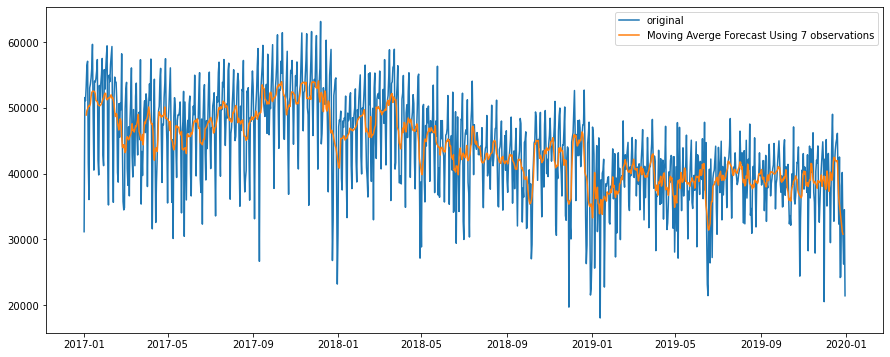

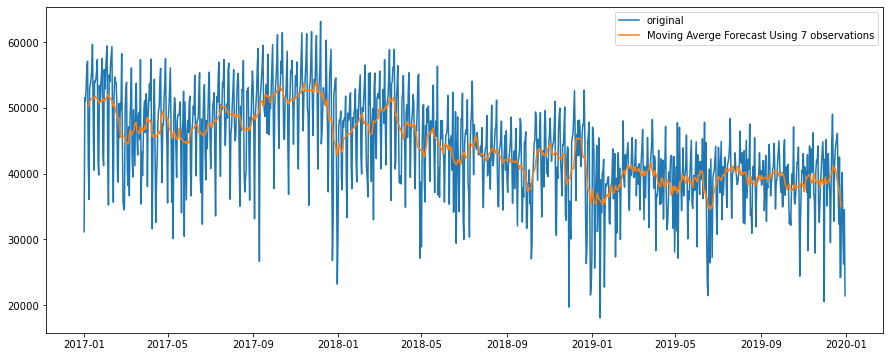

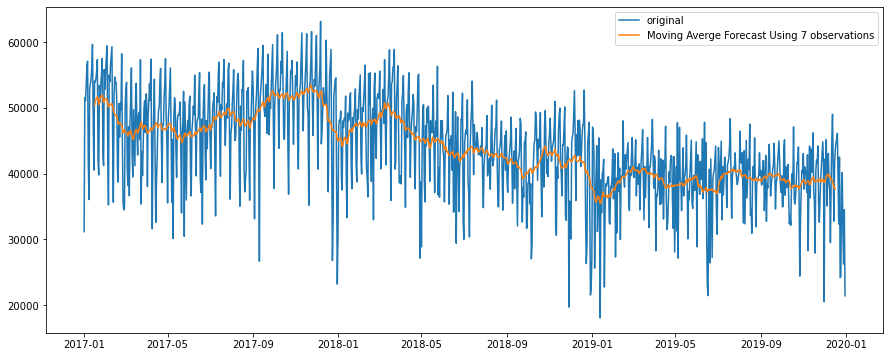

In [35]:
#Se realizan 3 ventanas distintas: una semana, dos semanas y un mes (30 días)

#Una semana
ventana = diario.copy()
ventana['moving_avg_forecast'] = diario['cantidad_pasos'].rolling(7, center=True).mean()
ventana = pd.DataFrame(ventana).set_index(diario.index.values)
plt.figure(figsize = (15,6))
plt.plot(diario['cantidad_pasos'], label='original')
plt.plot(ventana['moving_avg_forecast'], label= 'Moving Averge Forecast Using 7 observations')
plt.legend(loc='best')
plt.show()

#Dos semanas
ventana = diario.copy()
ventana['moving_avg_forecast'] = diario['cantidad_pasos'].rolling(14, center=True).mean()
ventana = pd.DataFrame(ventana).set_index(diario.index.values)
plt.figure(figsize = (15,6))
plt.plot(diario['cantidad_pasos'], label='original')
plt.plot(ventana['moving_avg_forecast'], label= 'Moving Averge Forecast Using 7 observations')
plt.legend(loc='best')
plt.show()

ventana = diario.copy()
ventana['moving_avg_forecast']=  diario['cantidad_pasos'].rolling(30, center=True).mean()
ventana = pd.DataFrame(ventana).set_index(diario.index.values)
plt.figure(figsize = (15,6))
plt.plot(diario['cantidad_pasos'], label='original')
plt.plot(ventana['moving_avg_forecast'], label= 'Moving Averge Forecast Using 7 observations')
plt.legend(loc='best')
plt.show()

**Análisis**: puede apreciarse que, a medida que se extiende la ventana, la media móvil se suaviza.

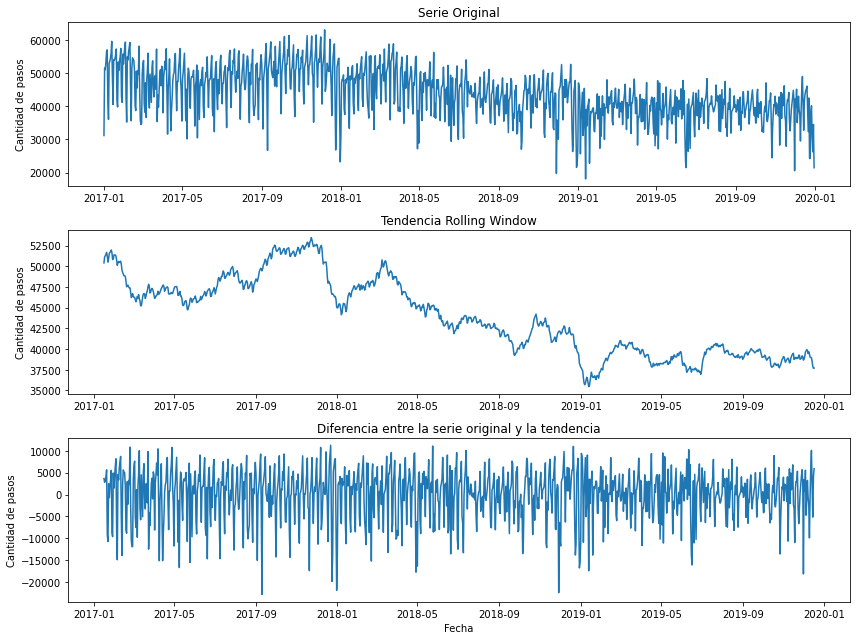

In [36]:
#Gráfico de la diferencia entre la serie original y la tendencia
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(ventana.moving_avg_forecast)
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - ventana.moving_avg_forecast)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')

plt.tight_layout()
plt.show()

#### Tendencia lineal

In [37]:
#Creación de un nuevo campo para obtener la fecha en números enteros
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)
diario.head()

,cantidad_pasos,fecha_numeros
fecha,,
2017-01-01,31183.0,736330
2017-01-02,51568.0,736331
2017-01-03,51093.0,736332
2017-01-04,53332.0,736333
2017-01-05,56486.0,736334


In [38]:
#Definición de la regresión lineal
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

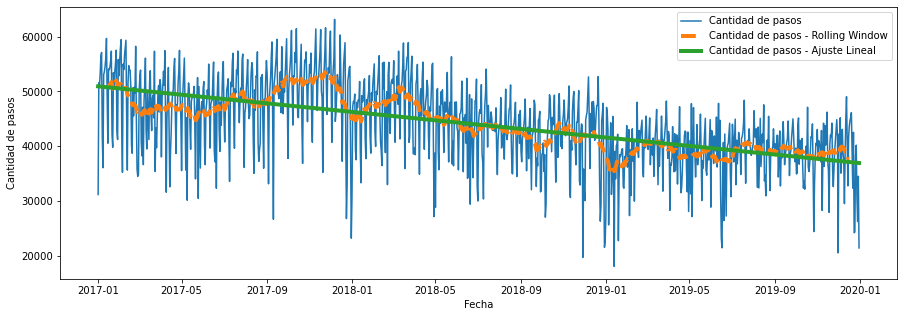

In [39]:
#Gráfico de la tendencia lineal
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(ventana.moving_avg_forecast, ls = '--', lw = 4, label = 'Cantidad de pasos - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de pasos - Ajuste Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

**Análisis**: el ajuste lineal pareciera capturar la tendencia descendiente general de la serie, pero sigue siendo una manera imperfecta de representar una serie con tanta variación.

#### Descomposición

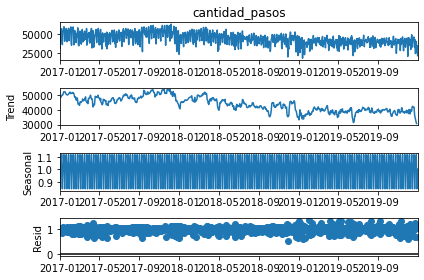

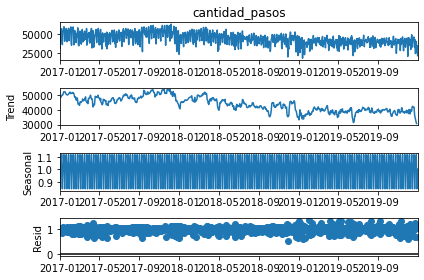

In [40]:
#Descomposición de la serie
result = seasonal_decompose(diario.cantidad_pasos, model='multiplicative')
result.plot()

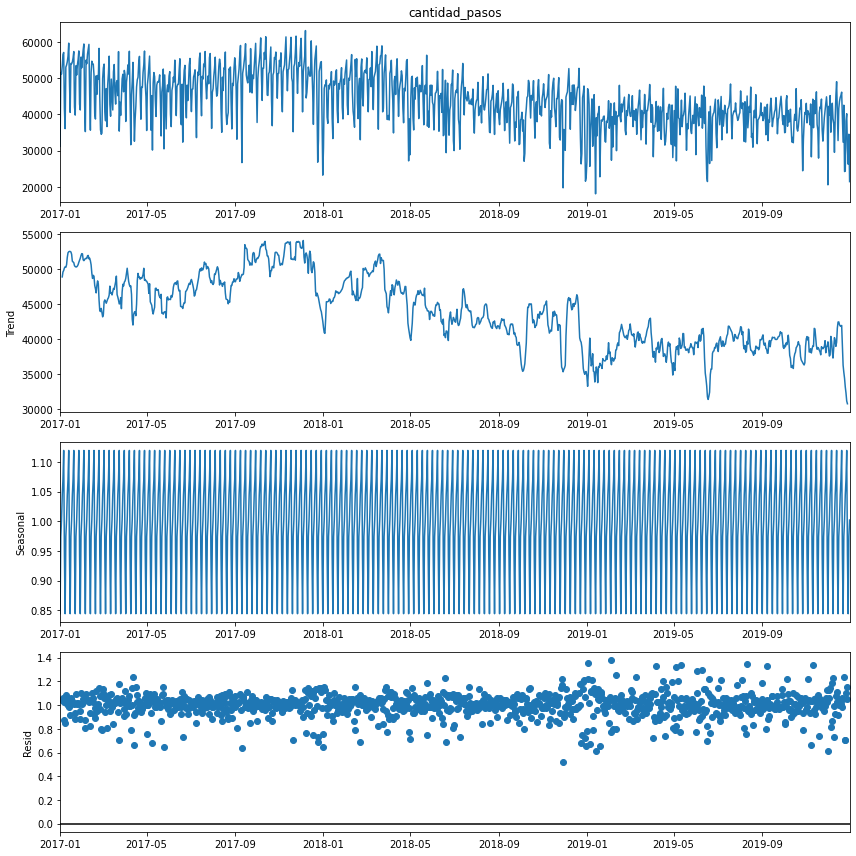

In [41]:
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

**Análisis**: de manera similar a los gráficos anteriores, la descomposición de la serie permite observar una tendencia negativa.

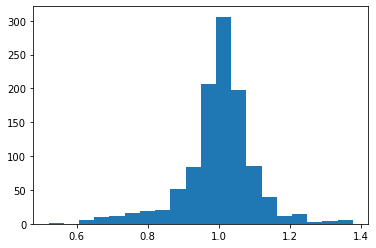

In [42]:
#Histograma de los residuos
plt.figure(figsize = (6,4))
plt.hist(result.resid, bins = 20)
plt.show()

**Análisis**: puede apreciarse que los residuos presentan una distribución normal.

### Predicción a futuro

#### Selección de la métrica de evaluación
Para todos los modelos de este proyecto, se utilizarán como métricas de evaluación tanto la **raíz del error cuadrático medio** (RMSE) y el **coeficiente de determinación** (r2). 

En el caso del RMSE, se buscarán obtener valores más bajos. Para el coeficiente de determinación, en cambio, se buscará acercar el coeficiente a 1.

In [43]:
#Elimino la columna con la fecha expresada en números enteros
diario.drop(columns = ['fecha_numeros'], inplace = True)
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


In [44]:
#Impresión del shape del nuevo dataset
diario.shape

(1095, 1)

In [45]:
#Definición del lookback para el modelo
look_back = 90*1

In [46]:
#Definición de x e y
N=diario.shape[0]
X= np.zeros((N-look_back-1, look_back))
y= np.zeros(N-look_back-1)

print(X.shape, y.shape)

(1004, 90) (1004,)


In [47]:
#Definición de la función
for i in range(X.shape[0]):
    X[i,:] = diario.values[i:i+look_back].ravel()
    y[i] = diario.values[i+look_back]

In [48]:
#Separación entre datos de entrenamiento y evaluación
N_train = 2*365 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 365 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(640, 90) (640,)
(364, 90) (364,)


**Benchmark**

El modelo benchmark se realizará utilizando la predicción resultante de la copia del valor de la fecha anterior

In [49]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

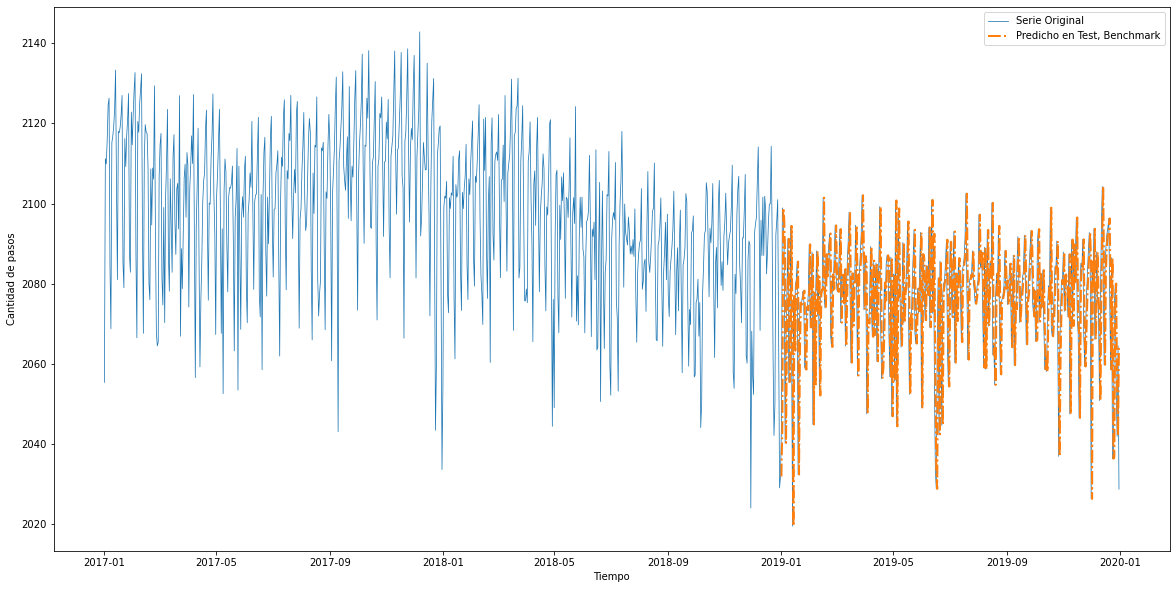

In [50]:
plt.figure(figsize=(20,10))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.plot(diario.index[N_train+look_back-1], diario.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

In [51]:
y_test_pred_benchmark = y[-1 + N_train-1:N_train-1+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train-1+N_test - 1])
print('Raíz del error cuadrático medio:',np.sqrt(MSE))

Raíz del error cuadrático medio: 6637.327662316175


### Random Forest

In [52]:
#Definición del modelo de regresión con random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [53]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

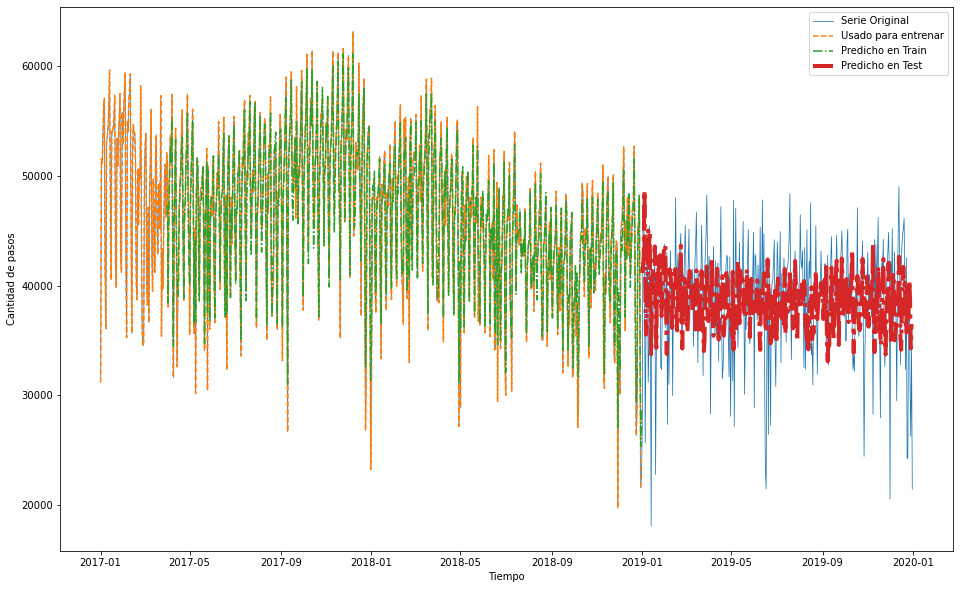

In [54]:
plt.figure(figsize=(16,10))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back - 1], diario[:N_train + look_back - 1],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

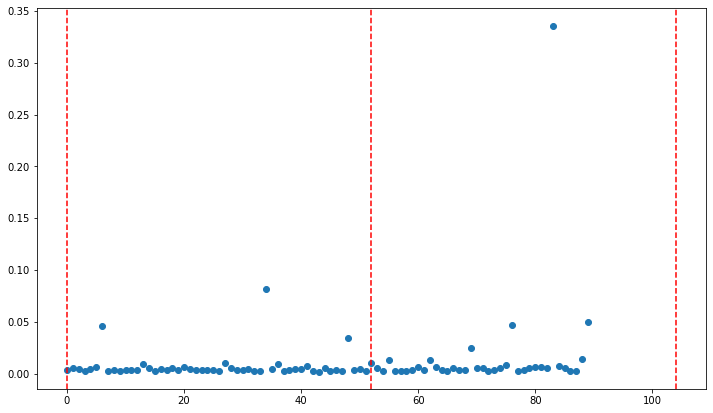

In [55]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*52:
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


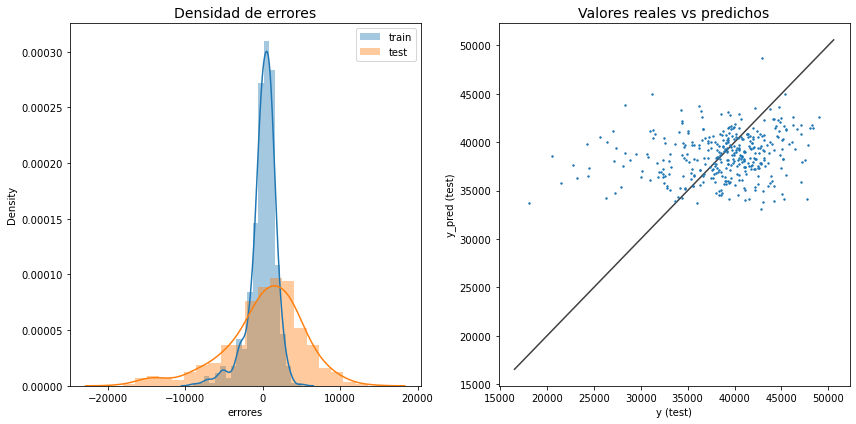

Raíz del error cuadrático medio en Train: 1762.90216022728
Raíz del error cuadrático medio en Test: 5161.010950398072
r2 en Train: 0.9396365534028213
r2 en Test: -0.03717819773578168


In [56]:
#Gráfico de valores reales vs valores predichos para el Random Forest con hiperparámetros iniciales y evaluación del modelo
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
plt.title('Densidad de errores',fontsize=14)


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),
np.max([ax.get_xlim(), ax.get_ylim()]),
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Valores reales vs predichos',fontsize=14)
    
plt.tight_layout()
plt.show()

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'r2 en Train: {r2_train}')
print(f'r2 en Test: {r2_test}')

**Análisis**: la distribución de errores graficada con los histogramas es de carácter simétrica, similar a una distribución de tipo gaussiana. Además, las distribuciones son consistentes entre los conjuntos de train y test. Por ende, puede afirmarse que la aproximación de los datos es adecuada. En cuanto al gráfico de los valores de y vs y_pred en los datos de test, puede apreciarse que los puntos se ubican cerca de la recta, lo cual es indicador de que el modelo es un buen regresor. 

Respecto al modelo benchmark, el Random Forest, con sus hiperparámetros iniciales, tiene mejores resultados.

#### **Multi-Step Prediction**

In [57]:
y_ms_test_pred = []
x = X_test[0,:]
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

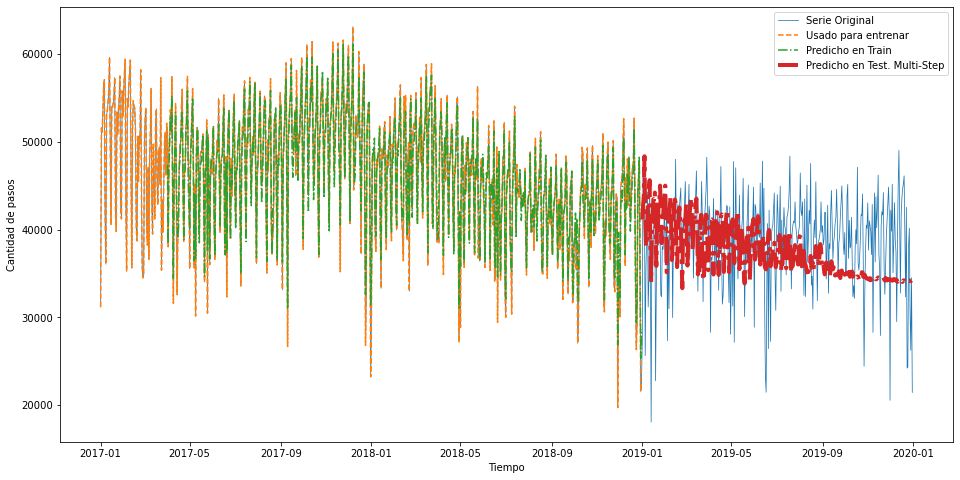

In [58]:
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total - 1], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [59]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 5649.297806160235


**Optimización de hiperparámetros - Random Forest**

In [60]:
tscv = TimeSeriesSplit(n_splits = 5)

# Grilla para Random Search
param_dist = {'max_depth':sp.stats.randint(1, 10),
              'n_estimators':sp.stats.randint(1, 25),
              'criterion': ['mse', 'mae'], 
              'min_samples_split':[2,3,4],
              'min_samples_leaf':[2,3,4]}


# Definición del random search
model = RandomizedSearchCV(rf, param_dist,n_iter=25, random_state=0, cv=tscv,n_jobs=-1,verbose=5)

In [61]:
#Entrenamiento del random forest con la grilla definida arriba y CV con tamaño de Fold=5
model.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(n_jobs=4, random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4320e7160>,
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe43226b970>},
                   random_state=0, verbose=5)

In [62]:
# Impresión de los mejores parámetros para el modelo de random forest
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores parametros: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 8}
Mejor Score: 0.40853236818556715



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.233284,0.034503,0.016574,0.010635,mse,6,2,3,20,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.440430,0.426682,0.440688,0.360900,0.305385,0.394817,0.053570,2
1,0.503489,0.393681,0.014007,0.015111,mae,3,2,4,13,"{'criterion': 'mae', 'max_depth': 3, 'min_samp...",0.232840,0.316708,0.186399,-0.340520,0.019352,0.082956,0.232888,16
2,0.139251,0.012651,0.011852,0.008267,mse,2,4,4,18,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",0.356126,0.332978,0.421349,0.356958,0.206591,0.334800,0.070537,8
3,0.851221,0.617605,0.005723,0.000297,mae,9,3,2,20,"{'criterion': 'mae', 'max_depth': 9, 'min_samp...",0.275467,0.304528,0.171171,-0.243278,0.102282,0.122034,0.196521,12
4,0.107505,0.034433,0.005172,0.000230,mse,4,3,4,16,"{'criterion': 'mse', 'max_depth': 4, 'min_samp...",0.442131,0.416147,0.460856,0.355051,0.261427,0.387122,0.072295,4
5,0.346628,0.230594,0.005242,0.000474,mae,1,4,2,18,"{'criterion': 'mae', 'max_depth': 1, 'min_samp...",0.153744,0.186454,0.106460,-0.505641,-0.055249,-0.022846,0.255285,19
6,0.077081,0.069189,0.002602,0.000060,mae,4,4,2,2,"{'criterion': 'mae', 'max_depth': 4, 'min_samp...",0.010657,0.261249,-0.003318,-0.513477,0.129812,-0.023015,0.263149,20
7,0.407083,0.338541,0.005834,0.000371,mae,1,4,2,24,"{'criterion': 'mae', 'max_depth': 1, 'min_samp...",0.175098,0.184108,0.099788,-0.458129,-0.085839,-0.016995,0.240964,18
8,0.061683,0.048901,0.000951,0.000006,mae,3,2,4,1,"{'criterion': 'mae', 'max_depth': 3, 'min_samp...",0.245031,0.093615,0.052219,-1.672000,0.038542,-0.248519,0.715513,25
9,0.036964,0.013278,0.006259,0.002425,mse,5,3,3,7,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.585407,0.383912,0.423339,0.283344,0.283537,0.391908,0.111377,3


/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


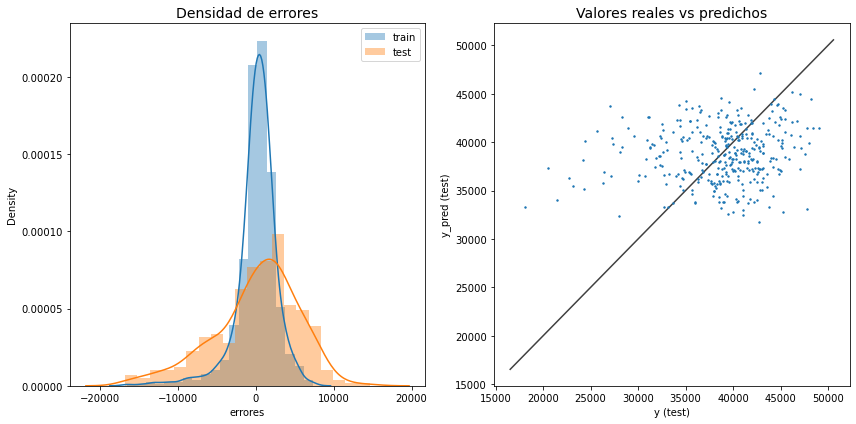

Raíz del error cuadrático medio en Train: 2694.5869983456955
Raíz del error cuadrático medio en Test: 5461.484552620969
r2 en Train: 0.8589730774716103
r2 en Test: -0.16146261986831223


In [63]:
#Gráfico de valores reales vs valores predichos para el Random Forest con hiperparámetros iniciales y evaluación del modelo
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
plt.title('Densidad de errores',fontsize=14)


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),
np.max([ax.get_xlim(), ax.get_ylim()]),
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Valores reales vs predichos',fontsize=14)
    
plt.tight_layout()
plt.show()

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'r2 en Train: {r2_train}')
print(f'r2 en Test: {r2_test}')

**Análisis**: la distribución de errores graficada con los histogramas es de carácter simétrica, similar a una distribución de tipo gaussiana. Además, las distribuciones son consistentes entre los conjuntos de train y test. Por ende, puede afirmarse que la aproximación de los datos es adecuada. En cuanto al gráfico de los valores de y vs y_pred en los datos de test, puede apreciarse que los puntos se ubican cerca de la recta, lo cual es indicador de que el modelo es un buen regresor. 

### Predicción 2020

Antes de incorporar al dataset los datos de 2020, verifico que contenga los mismos campos para las valores que voy a filtrar ('estación' y 'forma de pago')

In [64]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [65]:
print(data_2020['estacion'].unique())
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [66]:
print(data_2020['forma_pago'].unique())
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP' 'Mercado Pago']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Puede observarse que para el dataset de 2020, tanto la estación Illia como la forma de pago efectivo están en mayúsculas (a diferencia de los 3 años anteriores). Por ende, primero se va a preparar por separado el dataset para 2020, y luego se agregarán los años anteriores

In [67]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion','dia_fecha'], inplace = True)

data_2020.head()

,fecha,mes,dia,hora_fin,tipo_vehiculo,observacion,sentido,cantidad_pasos
52,2020-01-01 00:00:00,enero,Miércoles,1.0,Auto,Efectivo,Centro,326.0
53,2020-01-01 00:00:00,enero,Miércoles,1.0,Auto,Efectivo,Provincia,319.0
134,2020-01-01 00:00:00,enero,Miércoles,2.0,Auto,Efectivo,Centro,199.0
135,2020-01-01 00:00:00,enero,Miércoles,2.0,Auto,Efectivo,Provincia,180.0
202,2020-01-01 00:00:00,enero,Miércoles,3.0,Auto,Efectivo,Centro,114.0


In [68]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

,mes,dia,tipo_vehiculo,observacion,sentido,cantidad_pasos,fecha2
52,enero,Miércoles,Auto,Efectivo,Centro,326.0,2020-01-01 01:00:00
53,enero,Miércoles,Auto,Efectivo,Provincia,319.0,2020-01-01 01:00:00
134,enero,Miércoles,Auto,Efectivo,Centro,199.0,2020-01-01 02:00:00
135,enero,Miércoles,Auto,Efectivo,Provincia,180.0,2020-01-01 02:00:00
202,enero,Miércoles,Auto,Efectivo,Centro,114.0,2020-01-01 03:00:00


In [69]:
#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

,mes,dia,tipo_vehiculo,observacion,sentido,cantidad_pasos,fecha
52,enero,Miércoles,Auto,Efectivo,Centro,326.0,2020-01-01 01:00:00
53,enero,Miércoles,Auto,Efectivo,Provincia,319.0,2020-01-01 01:00:00
134,enero,Miércoles,Auto,Efectivo,Centro,199.0,2020-01-01 02:00:00
135,enero,Miércoles,Auto,Efectivo,Provincia,180.0,2020-01-01 02:00:00
202,enero,Miércoles,Auto,Efectivo,Centro,114.0,2020-01-01 03:00:00


In [70]:
#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)
data_2020

,mes,dia,tipo_vehiculo,observacion,sentido,cantidad_pasos,fecha
0,enero,Miércoles,Moto,Efectivo,Centro,7.0,2020-01-01 00:00:00
1,enero,Miércoles,Auto,Efectivo,Provincia,423.0,2020-01-01 00:00:00
2,enero,Miércoles,Auto,Efectivo,Centro,467.0,2020-01-01 00:00:00
3,enero,Miércoles,Moto,Efectivo,Provincia,6.0,2020-01-01 00:00:00
4,enero,Miércoles,Pesados 2 Ejes,Efectivo,Centro,1.0,2020-01-01 00:00:00
...,...,...,...,...,...,...,...
52369,diciembre,Jueves,Auto,Efectivo,Provincia,222.0,2020-12-31 20:00:00
52370,diciembre,Jueves,Auto,Efectivo,Provincia,106.0,2020-12-31 21:00:00
52371,diciembre,Jueves,Moto,Efectivo,Centro,5.0,2020-12-31 21:00:00
52372,diciembre,Jueves,Moto,Efectivo,Provincia,1.0,2020-12-31 21:00:00


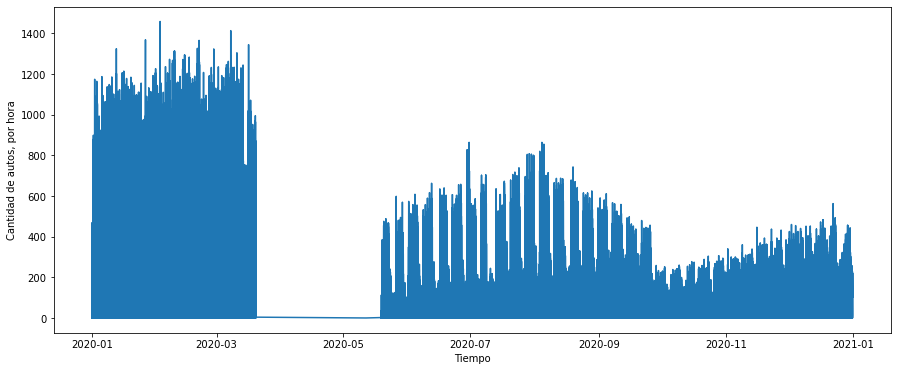

In [71]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(data_2020.fecha, data_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [72]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario_2020 = data_2020.resample('D', on = 'fecha').sum()
print(diario_2020.shape)
diario_2020.head()

(366, 1)


,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


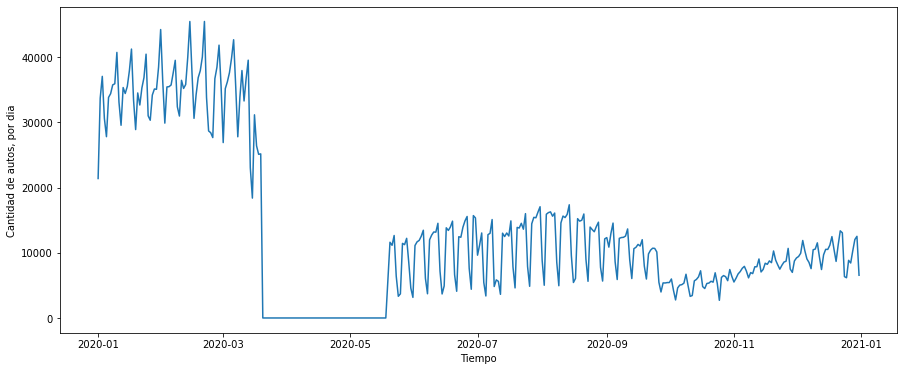

In [73]:
plt.figure(figsize = (15,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [74]:
#Unimos todos los datasets
diario2020 = pd.concat([diario,diario_2020])
diario2020.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


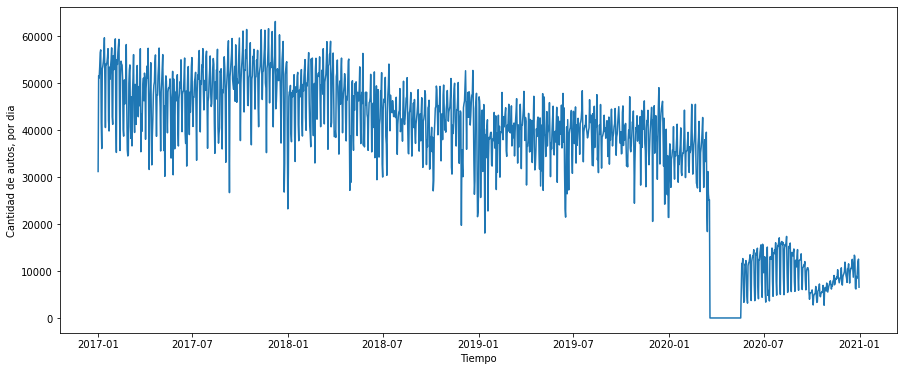

In [75]:
plt.figure(figsize = (15,6))
plt.plot(diario2020.index, diario2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

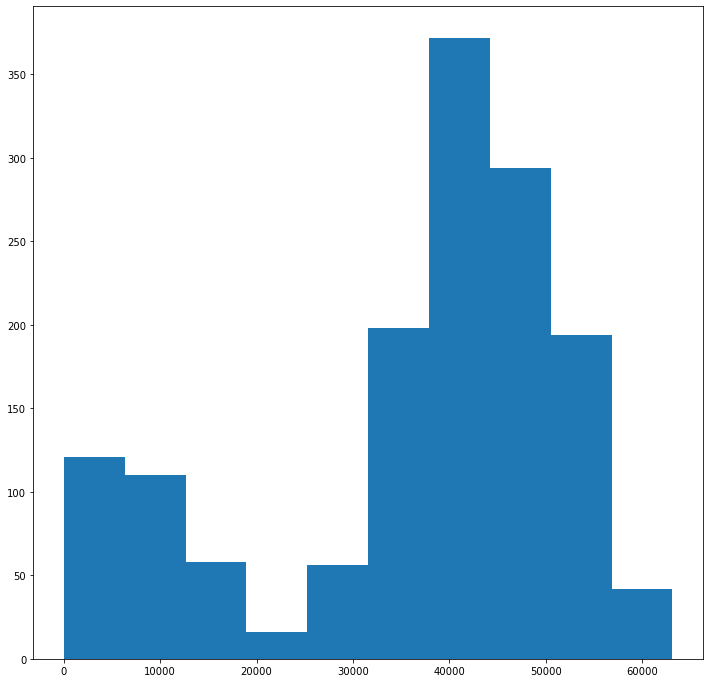

In [76]:
#Histograma para ver cómo es la distribución de la cantidad de pasos por día
plt.hist(diario2020.cantidad_pasos)
plt.show()

In [77]:
#Copia del dataset original
dt_original_2020 = diario2020.copy()
dt_original_2020.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


<AxesSubplot:xlabel='fecha'>

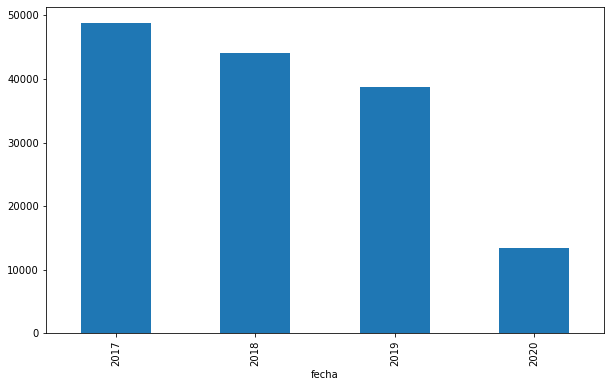

In [78]:
#Conteo por año
dt_original_2020.reset_index(inplace=True)

plt.figure(figsize = (10,6))
dt_original_2020.groupby(dt_original_2020.fecha.dt.year)['cantidad_pasos'].mean().plot.bar()

### Modelo

In [79]:
#Impresión del shape del nuevo dataset
diario2020.shape

(1461, 1)

In [80]:
#Definición del lookback para el modelo
look_back = 90*1

In [81]:
#Definición de x e y
N=diario2020.shape[0]
X= np.zeros((N-look_back-1, look_back))
y= np.zeros(N-look_back-1)

print(X.shape, y.shape)

(1370, 90) (1370,)


In [82]:
#Definición de la función
for i in range(X.shape[0]):
    X[i,:] = diario2020.values[i:i+look_back].ravel()
    y[i] = diario2020.values[i+look_back]

In [83]:
#Separación entre datos de entrenamiento y evaluación
N_train = 3*365 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 365 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1005, 90) (1005,)
(365, 90) (365,)


In [84]:
#Definición del modelo de regresión con random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

In [85]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

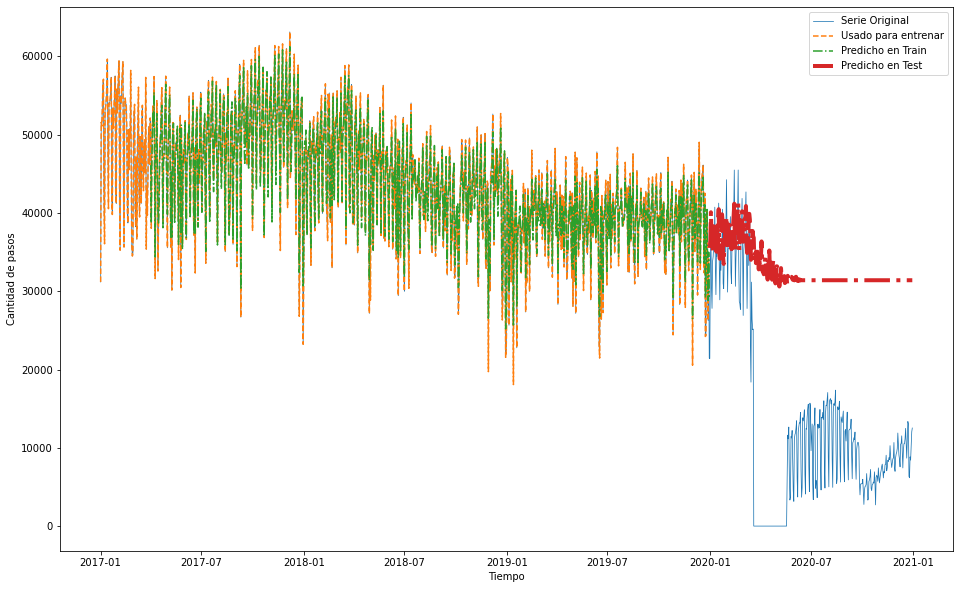

In [86]:
plt.figure(figsize=(16,10))
plt.plot(diario2020.index[:length_total], diario2020[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario2020.index[:N_train + look_back - 1], diario2020[:N_train + look_back - 1],'--', label = 'Usado para entrenar')
plt.plot(diario2020.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario2020.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

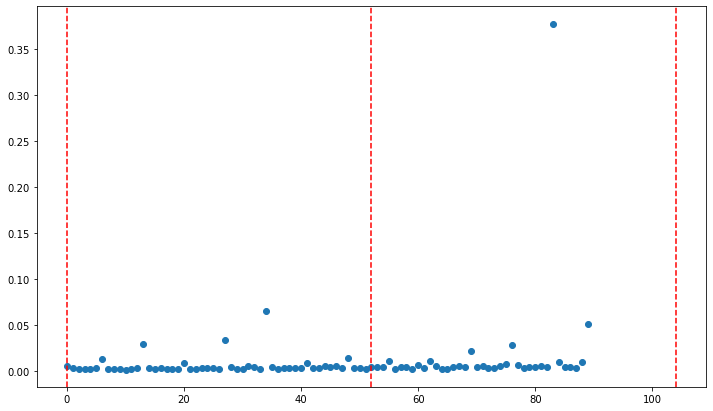

In [87]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(3)*52:
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pedrofregonese/opt/miniconda3/envs/datascience/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


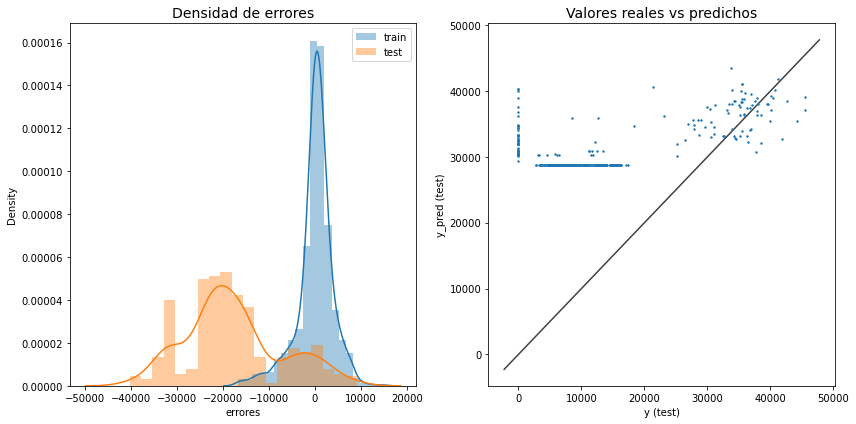

Raíz del error cuadrático medio en Train: 3944.749101448942
Raíz del error cuadrático medio en Test: 20631.380527322068
r2 en Train: 0.7177621381405948
r2 en Test: -1.8516368705965704


In [88]:
#Gráfico de valores reales vs valores predichos para el Random Forest con hiperparámetros iniciales y evaluación del modelo
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()
plt.title('Densidad de errores',fontsize=14)


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),
np.max([ax.get_xlim(), ax.get_ylim()]),
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.title('Valores reales vs predichos',fontsize=14)
    
plt.tight_layout()
plt.show()

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'r2 en Train: {r2_train}')
print(f'r2 en Test: {r2_test}')

**Análisis**: a pesar de que la distribución de errores graficada con los histogramas es de carácter simétrica y similar a una distribución de tipo gaussiana, entre los conjuntos de train y test las distribuciones difieren fuertemente. Por ende, puede afirmarse que la aproximación de los datos es incorrecta. En cuanto al gráfico de los valores de y vs y_pred en los datos de test, se observa una gran distancia entre los puntos y la recta, indicando que el modelo no es un buen regresor.